In [22]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from utilities import *
from VoxelGrid import *
device='cuda'


In [23]:
focal, all_c2w, all_gt = get_data("../nerf_synthetic/drums/")

LOAD DATA ../nerf_synthetic/drums/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.74it/s]


In [24]:
H, W = all_gt[0].shape[:2]

In [25]:
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]

In [26]:
camera_centers = get_cameras_centers(rays_or_dir)

In [27]:
bound_w = 1.5
size = 20
VG = VoxelGrid(size, bound_w)
x = np.linspace(-bound_w,bound_w,size)
y = np.linspace(-bound_w,bound_w,size)
z = np.linspace(-bound_w,bound_w,size)
xx,yy,zz = np.meshgrid(x,y,z)

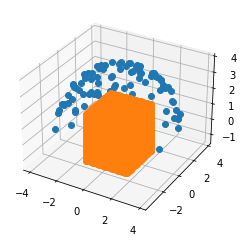

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( xx.flatten(),yy.flatten(),zz.flatten(), 'o')


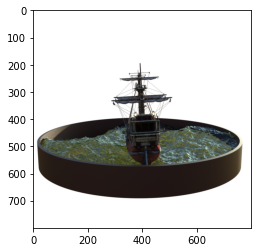

In [18]:
plt.imshow(all_gt[0])

In [19]:
rays_or_dir = get_rays_np(H,W, focal, all_c2w[0])

In [20]:
rays_or_dir[1][0,0]

array([1.06319213, 0.31035228, 0.17848331])

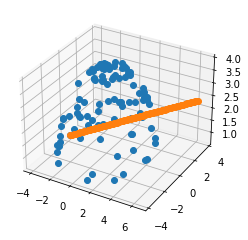

In [21]:
p = rays_or_dir[0][0,0]+ np.arange(100)[:, None]/10*rays_or_dir[1][0,0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( p[:,0], p[:,1], p[:,2], 'o')

In [13]:
# target_im = all_gt[0]
# rays = rays_or_dir[0][..., None] + np.arange(100)/10*rays_or_dir[1][..., None]

red = 8
target_im = all_gt[0][::red,::red,:]
rays = rays_or_dir[0][::red,::red,:, None] + np.arange(100)/10*rays_or_dir[1][::red, ::red,:, None]



In [14]:
target_im.shape

(100, 100, 3)

In [27]:

losses=[]
for x in tqdm(range(target_im.shape[0])):
    for y in range(target_im.shape[0]):
        # x = np.random.randint(0,800)
        # y = np.random.randint(0,800)

        pixel_target = torch.tensor(target_im[x,y])

        ray = torch.tensor(rays[x,y].T, dtype=torch.float32)

        pix_estim = VG.render_ray(ray)

        loss = ((pix_estim-pixel_target)**2).sum()

        loss.backward()
        losses.append(loss.item())

        VG.update_grads(0.1)



100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


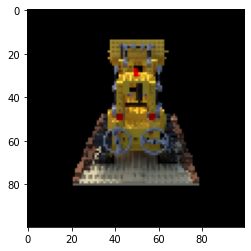

In [28]:
plt.imshow(target_im)

In [29]:
n_red = 5

new_im = np.zeros_like(target_im)
for x in tqdm(range(target_im.shape[0])):
    for y in range(target_im.shape[1]):
        ray = torch.tensor(rays[x,y].T, dtype=torch.float32)

        pix_estim = VG.render_ray(ray)
        new_im[x,y, :] = pix_estim.detach().numpy()

100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


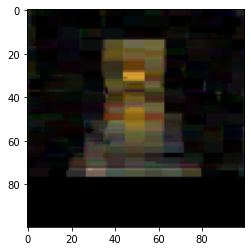

In [30]:
%matplotlib inline
plt.imshow(new_im)

(array([2.500e+01, 8.640e+02, 2.064e+03, 2.095e+03, 2.130e+03, 7.510e+02,
        4.500e+01, 1.800e+01, 7.000e+00, 1.000e+00]),
 array([-0.42758888, -0.15863408,  0.11032071,  0.37927551,  0.6482303 ,
         0.9171851 ,  1.18613989,  1.45509469,  1.72404948,  1.99300428,
         2.26195908]),
 <BarContainer object of 10 artists>)

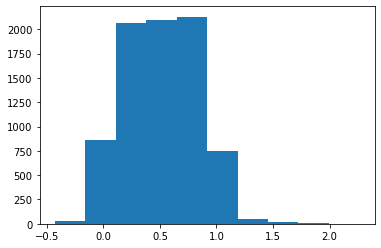

In [31]:
plt.hist(VG.opacities.tolist())